In [4]:
import numpy as np
from pathlib import Path
import tensorflow as tf
import sys
import os
from datetime import datetime

from sklearn.metrics import classification_report
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import (
    auc,
    average_precision_score,
    precision_recall_curve,
    roc_curve,
)
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics


2023-02-06 16:44:42.231270: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt


In [6]:
import numpy as np
from pathlib import Path
from tqdm import tqdm
from scipy.io import loadmat
import random
import math
from numpy import genfromtxt
import resampy
import matplotlib.pyplot as plt

In [60]:
!pip install seaborn


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
data_root = Path("/data/stg60/milton_plotdata/test1/")
data_milton_par = Path("/data/stg60/milton_plotdata/Milton_for_parameter_est/")
#data_milton_par = Path("/data/stg60/milton_plotdata/test/")
data_milton_pred=Path("/data/stg60/milton_plotdata/Milton_for_prediction/")

In [6]:
def strides(a, L = 128, S=1):  # Window len = L, Stride len/stepsize = S
    tolist = False
    if isinstance(a, list):
        tolist = True
        a = np.array(a)
    if S is None:
        S = math.ceil(a.size/10)
    nrows = ((a.size - L) // S) + 1
    n = a.strides[0]
    #print(n)
    windows = np.lib.stride_tricks.as_strided(a, shape=(nrows, L), strides=(S * n, n))
    
    if tolist:
        windows = windows.tolist()
    return windows
def read_tsv(tsv, start_index = 1024, end_index = None, scale = True):
    dat = genfromtxt(tsv, delimiter='\t')
    x1,x2,x3,x4,x5,x6 = np.hsplit(dat,6)
    ell_1=((x1-x4)**2+(x2-x5)**2+(x3-x6)**2)**0.5 + 1e-10
    ang_sin_x_1=(x1-x4)/ell_1
    phi =np.arcsin(ang_sin_x_1)*180/np.pi
    phi = phi.reshape(-1)[start_index:end_index]
    x1 = x1.reshape(-1)[start_index:end_index]
    phi = resampy.resample(phi, sr_orig = 250, sr_new = 100)
    x1 = resampy.resample(x1, sr_orig = 250, sr_new = 100)
    if scale:
        phi = phi/20
        x1 = x1/0.335
    return phi, x1
def prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1, start_index = 1024, end_index = None, scale = True):
    """AI is creating summary for prepareData

    Args:
        path ([Str]): [path to the original file]
        cutoff (int, optional): [description]. Defaults to 128.
        delay (int, optional): [description]. Defaults to 23.
        L (int, optional): [Window size]. Defaults to 128.
        timetopredict (float, optional): [description]. Defaults to 1.96.
        samplingrate (int, optional): [description]. Defaults to 100.
        fall_stride (int, optional): [description]. Defaults to 1.
        start_index (int, optional): [description]. Defaults to 1024.
        end_index ([type], optional): [description]. Defaults to None.
        scale (bool, optional): [description]. Defaults to True.
    Returns:
        [type]: [description]

    Yields:
        [type]: [description]
    """
    # timetopredict in seconds, note 1 point = 0.01 seconds, or 100points = 1seconds
    def disect(*args, separator = None):
        for arg in args:
            nofall, fall = arg[:-separator], arg[-separator:]
            yield (nofall, fall)
    
    if path.suffix == ".mat":    
        if not isinstance(path, str):
            path = path.as_posix()
        mat = loadmat(path)
        phiv = mat['phiv'].reshape(-1)
        dxv = mat['dxv'].reshape(-1)
        if scale:
            phiv = phiv/20
            dxv = dxv/0.335
    elif path.suffix == ".tsv":
        phiv, dxv = read_tsv(path, start_index = start_index, end_index=end_index)
  
    phiv = phiv[:-cutoff]
    dxv = dxv[:-cutoff]

    #phiv -> delay, respo
    delay_phiv = phiv[delay:]
    respo_phiv = phiv[:-delay]

    #dxv -> delay, respo
    delay_dxv = dxv[delay:]
    respo_dxv = dxv[:-delay]

    #fall region
    fall_region = L + int(timetopredict*samplingrate)
    [(n_delay_phiv, f_delay_phiv), (n_respo_phiv, f_respo_phiv)] = disect(delay_phiv, respo_phiv, separator=fall_region)
    [(n_delay_dxv, f_delay_dxv), (n_respo_dxv, f_respo_dxv)] = disect(delay_dxv, respo_dxv, separator=fall_region)

    if n_delay_phiv.size < f_delay_phiv.size:
        S = 1
    else:
        S = math.ceil((n_delay_phiv.size - f_delay_phiv.size)/(timetopredict*samplingrate+1))

    #s=1 for imbalanced
    # no_fall_windows(imbalanced)
    n_delay_phiv = strides(n_delay_phiv, L = L, S = S)
    n_respo_phiv = strides(n_respo_phiv, L = L, S = S)
    n_delay_dxv = strides(n_delay_dxv, L = L, S = S)
    n_respo_dxv = strides(n_respo_dxv, L = L, S = S)

    # fall_windows
    f_delay_phiv = strides(f_delay_phiv, L = L, S = fall_stride)
    #f_delay_phiv1 = strides(f_delay_phiv, L = L, S = fall_stride)
    f_respo_phiv = strides(f_respo_phiv, L = L, S = fall_stride)
    f_delay_dxv = strides(f_delay_dxv, L = L, S = fall_stride)
    f_respo_dxv = strides(f_respo_dxv, L = L, S = fall_stride)

    # concatenate features
    n_x = np.stack((n_delay_phiv,n_respo_phiv,n_delay_dxv,n_respo_dxv), -1)
    f_x = np.stack((f_delay_phiv,f_respo_phiv,f_delay_dxv,f_respo_dxv), -1)

    n_y = np.zeros(n_x.shape[0]).reshape(-1,1)
    f_y = np.ones(f_x.shape[0]).reshape(-1,1)

    x = np.concatenate((n_x,f_x), 0)
    y = np.concatenate((n_y,f_y), 0)

    return x, y, S

In [7]:
def getOneHugeArray(path_list, start_index_list = None, end_index_list = None):
    datax = []
    datay = []
    if start_index_list is None and end_index_list is None:    
        for path in tqdm(path_list):
            x,y,_= prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1)
            datax.append(x)
            datay.append(y)
    else:
        for path, start_index, end_index in tqdm(zip(path_list, start_index_list, end_index_list)):
            x,y,_= prepareData(path, cutoff = 128, delay = 23, L = 128, timetopredict = 1.96, samplingrate = 100, fall_stride = 1, start_index = start_index, end_index = end_index)
            datax.append(x)
            datay.append(y)
    x = np.concatenate(datax)    
    y = np.concatenate(datay)

    return x, y
def create_Real_Data(data_path_list, mode = "pred"):
    phi_data=[]
    data_path_list = sorted(data_path_list.glob('*.tsv'))
    start_index_list = [1024]*len(data_path_list)
    end_index_list = [None]*len(data_path_list)
    for x in tqdm(data_path_list):
        phi,dxv = read_tsv(x)
        phi_data.append(phi)
        plt.figure(figsize=(20,5))
        plt.plot(phi, label = x.name)
    plt.legend()
    plt.savefig(f"plots_{mode}.png")

    x, y= getOneHugeArray(data_path_list, start_index_list = start_index_list, end_index_list = end_index_list)
    # print(x)
    # print("break")
    # print(y)
    # # print(x[204])
    # print("break")
    # print(y[207])
    
    
    print(x.shape, y.shape, y.sum()/y.size)
    np.savez(data_root/f"{mode}.npz", x = x, y = y)
    return x,y,phi,dxv

In [8]:
def getAllMats(path = "/data/stg60/milton_plotdata/test/", sample = None, filter_required = True, L = 128, timetopredict = 1.96, samplingrate = 100):
    maxsize = int(timetopredict*samplingrate) + L*4 + 1
    data = sorted(Path(path).glob("milton*.mat"))
    if sample:
        data = random.sample(data, sample)
    if filter_required:
        data = list(filter(lambda x:abs(loadmat(x)['phiv']).max()>20 and loadmat(x)['phiv'].size>maxsize, data))
        print(data)
    return data

In [9]:
sim_path_list = getAllMats(sample=None)
print("The sampled sim_path_list is ", len(sim_path_list))


[PosixPath('/data/stg60/milton_plotdata/test/milton_sim_0000000994.mat')]
The sampled sim_path_list is  1


In [10]:
mat = loadmat('/data/stg60/milton_plotdata/test/milton_sim_0000000994.mat')
phiv_s = mat['phiv'].reshape(-1)
dxv_s = mat['dxv'].reshape(-1)
        
phiv_sim = phiv_s/20
dxv_sim = dxv_s/0.335

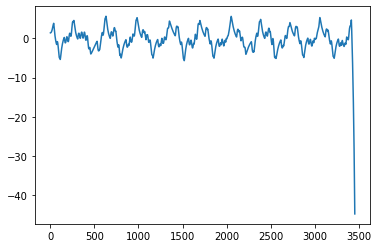

In [68]:
plt.plot(phiv_s)

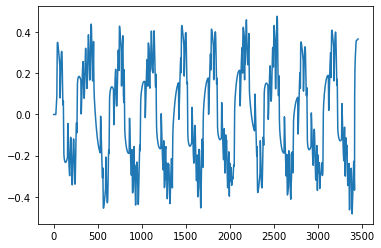

In [69]:
plt.plot(dxv_s)

In [11]:
phiv_sim = phiv_s[:-128]
delay_phiv_sim = phiv_sim[23:]
 
 

In [12]:
    phiv_sim = phiv_sim[:-128]
    dxv_sim = dxv_s[:-128]

    #phiv -> delay, respo
    delay_phiv_sim = phiv_sim[23:]
    respo_phiv_sim = phiv_sim[:-23]

    #dxv -> delay, respo
    delay_dxv_sim = dxv_sim[23:]
    respo_dxv_sim = dxv_sim[:-23]

In [24]:

dxv_sim.shape

(3329,)

In [13]:
xtest, ytest = getOneHugeArray(sim_path_list)
print(f"The shape of xtrain is {xtest.shape}, the ratio of fall/nofall : {ytest.sum()/ytest.size}")

100%|██████████| 1/1 [00:00<00:00, 97.21it/s]

The shape of xtrain is (401, 128, 4), the ratio of fall/nofall : 0.4912718204488778


In [14]:
len(xtest)

401

(array([-50., -40., -30., -20., -10.,   0.,  10.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

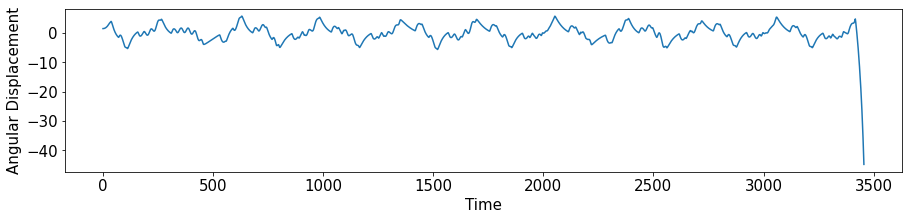

In [26]:
# plt.tick_params(axis='x', fontsize='17')
plt.figure(figsize=(15,3))
plt.plot(phiv_s)
plt.xlabel('Time', fontsize=15)
plt.ylabel('Angular Displacement', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

In [15]:

data_root.mkdir(exist_ok=True)

np.savez(data_root/"testsim994.npz", x = xtest, y = ytest)

In [46]:
#x,y,phi,dxv= create_Real_Data(data_milton_par, mode = "karl_20")



In [ ]:

plt.plot(phi)

In [9]:

trainpath = Path(f"/data/stg60/milton_plotdata/par.npz")
valpath = Path(f"/data/stg60/milton_plotdata/val.npz")
testpath = Path(f"/data/stg60/milton_plotdata/test1/testsim994.npz")
#testpath = Path(f"/data/stg60/milton_plotdata/test/karl_20.npz")

In [2]:
checkpoint_root = f"/data/stg60/new_savedmodel/version_1/"

checkpoint_path = f"{checkpoint_root}/model.ckpt"

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="4"
tf_device='/gpu:4'

NameError: name 'os' is not defined

In [11]:
BATCH_SIZE = 128
TEST_BATCH_SIZE = 28
SHUFFLE_BUFFER_SIZE = BATCH_SIZE * 128
limit=None
print('Train Loading')
with np.load(trainpath, allow_pickle=True) as data:
    train_examples = data['x'][:limit]
    train_labels = (data['y'][:limit]).astype(np.int64)

train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(8)
print('Train Loaded')

print('Val Loading')
with np.load(valpath, allow_pickle=True) as data:
    val_examples = data['x']
    val_labels = (data['y']).astype(np.int64)

val_dataset = tf.data.Dataset.from_tensor_slices((val_examples, val_labels)).prefetch(8)
val_dataset = val_dataset.batch(BATCH_SIZE)
print('Val Loaded')


print('Test Loading')
with np.load(testpath, allow_pickle=True) as data:
    test_examples = data['x']
    test_labels = (data['y']).astype(np.int64)

test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels)).prefetch(8)
test_dataset = test_dataset.batch(TEST_BATCH_SIZE)
print('Test Loaded')

: 

: 

In [79]:
len(test_examples)

401

In [80]:
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
train_data = train_dataset.with_options(options)
val_dataset = val_dataset.with_options(options)
test_dataset = test_dataset.with_options(options)

In [81]:
print("Creating a model")
tf.keras.backend.set_floatx('float64')

Creating a model


In [82]:
strategy = tf.distribute.MirroredStrategy

In [92]:


    model = tf.keras.Sequential([
        tf.keras.layers.InputLayer(input_shape=(128, 4)),
        tf.keras.layers.LayerNormalization(
            axis=1, epsilon=1e-10, center=True, scale=True,
            beta_initializer='zeros', gamma_initializer='ones',
        ),
        
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256, return_sequences=False)),
        
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(128, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(32, activation='relu'),
        # tf.keras.layers.Dropout(0.5),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.BatchNormalization(axis=-1,
                                           momentum=0.99,
                                           epsilon=0.001,
                                           ),
        tf.keras.layers.Dense(1)
    ])

    model.load_weights(checkpoint_path)

    regularizer = tf.keras.regularizers.l1(0.01)
    for layer in model.layers:
     for attr in ['kernel_regularizer']:
        if hasattr(layer, attr):
          setattr(layer, attr, regularizer)

    model.compile(optimizer=tf.keras.optimizers.SGD(),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics = ['accuracy']) 





   

2023-02-06 04:08:22.824399: W tensorflow/core/common_runtime/bfc_allocator.cc:433] Allocator (GPU_0_bfc) ran out of memory trying to allocate 32.0KiB (rounded to 32768)requested by op RandomUniform
Current allocation summary follows.
2023-02-06 04:08:22.824460: I tensorflow/core/common_runtime/bfc_allocator.cc:972] BFCAllocator dump for GPU_0_bfc
2023-02-06 04:08:22.824490: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (256): 	Total Chunks: 10, Chunks in use: 10. 2.5KiB allocated for chunks. 2.5KiB in use in bin. 80B client-requested in use in bin.
2023-02-06 04:08:22.824512: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (512): 	Total Chunks: 2, Chunks in use: 2. 1.0KiB allocated for chunks. 1.0KiB in use in bin. 1.0KiB client-requested in use in bin.
2023-02-06 04:08:22.824533: I tensorflow/core/common_runtime/bfc_allocator.cc:979] Bin (1024): 	Total Chunks: 9, Chunks in use: 9. 9.5KiB allocated for chunks. 9.5KiB in use in bin. 9.0KiB client-requested in use

ResourceExhaustedError: OOM when allocating tensor with shape[4,1024] and type double on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [89]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)


# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/model.ckpt',
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=True)

In [90]:
model.load_weights(checkpoint_path)

NameError: name 'model' is not defined

In [131]:
    print("Model Evaluation Started")
    
    y_prob = tf.sigmoid(model.predict(test_examples))
    y_out = (y_prob > 0.84).numpy().astype("int32")
    #y_out = (y_prob > 0.5).numpy().astype("int32")
    target_names = ['No-Fall', 'Fall']
    report = classification_report(test_labels, y_out, target_names=target_names, zero_division = 0)
    
    # with open(f"{rep_root}/test_report_version_{version_catalog}.txt","w") as f:
    #     f.write(report)
    print(report)

Model Evaluation Started
              precision    recall  f1-score   support

     No-Fall       0.93      0.67      0.78      2141
        Fall       0.11      0.46      0.18       197

    accuracy                           0.65      2338
   macro avg       0.52      0.56      0.48      2338
weighted avg       0.86      0.65      0.73      2338



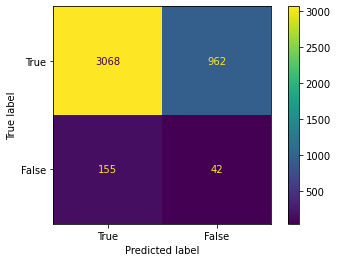

In [91]:
confusion_matrix = metrics.confusion_matrix(test_labels, y_out)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True,False])

cm_display.plot()
plt.show()

In [92]:
len(test_labels)

1263

In [69]:
len(test_examples)
test_examples.shape

(15512, 128, 4)

In [132]:
not_matched=[]
matched=[]
for i in range(0,len(test_labels)):
    if test_labels[i]!= y_out[i]:
        not_matched.append(i)
    else:
        matched.append(i)



     

In [71]:
len(not_matched)

1092

In [72]:
len(matched)

14420

In [157]:
# feature_1=[]
# for i in range(0,127):
#     feature_1.append(test_examples[2][i][0])
    

In [225]:
# feature1=[]
# for j in range (0,184):
#     col=[]
#     for i in range(0,127):
#         col.append(test_examples[not_matched[j]][i][0])

#     feature1.append(col)

In [72]:
# feature1_total=[]
# for j in range (0,1270):
#     col=[]
#     for i in range(0,128):
#         col.append(test_examples[j][i][0])

#     feature1_total.append(col)

In [102]:
# feature1_total=[]
# for j in range (0,400):
#     col=[]
#     for i in range(0,127):
#         col.append(test_examples[j][i][0])

#     feature1_total.append(col)

In [73]:
# feature1_total=np.array(feature1_total)
# feature1_total_flatten=feature1_total.flatten()

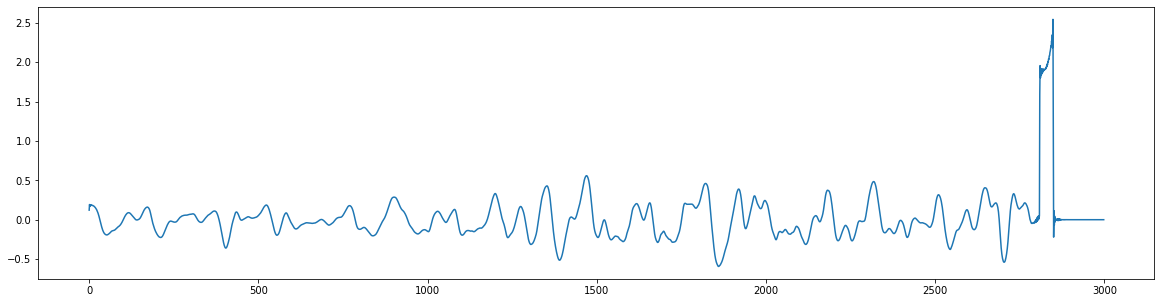

In [187]:
plt.figure(figsize=(20,5))
plt.plot(phi)

In [133]:
    phiv = phi[:-128]
    dxv = dxv[:-128]

    #phiv -> delay, respo
    delay_phiv = phiv[23:]
    respo_phiv = phiv[:-23]

    #dxv -> delay, respo
    delay_dxv = dxv[23:]
    respo_dxv = dxv[:-23]

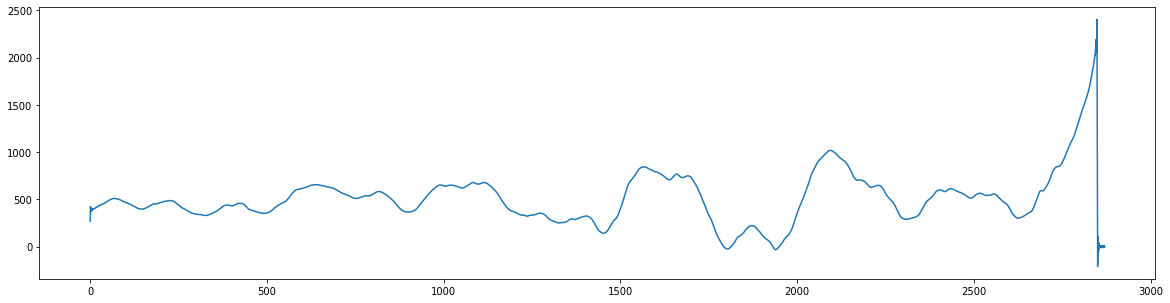

In [183]:
plt.figure(figsize=(20,5))
plt.plot(dxv)

In [134]:
len(not_matched)

808

In [135]:
test_examples.shape

(2338, 128, 4)

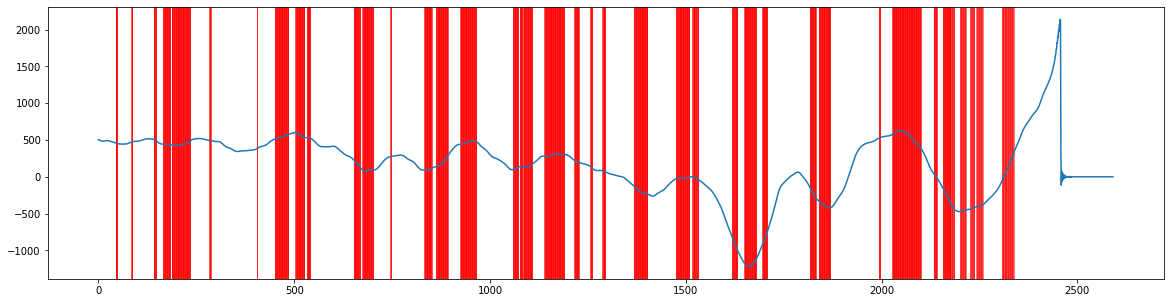

In [139]:

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(delay_dxv)
high=[]
low=[]

for j in range (0,2338):
    for i in range (0,808):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

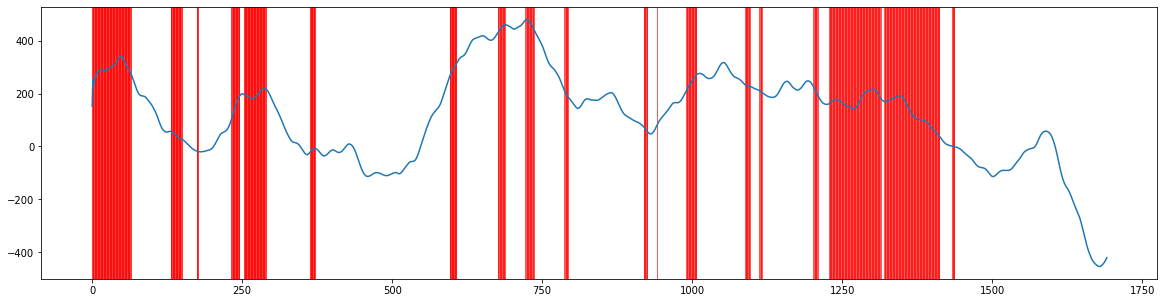

In [110]:
# milton_98
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(respo_dxv)
high=[]
low=[]

for j in range (0,1438):
    for i in range (0,427):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

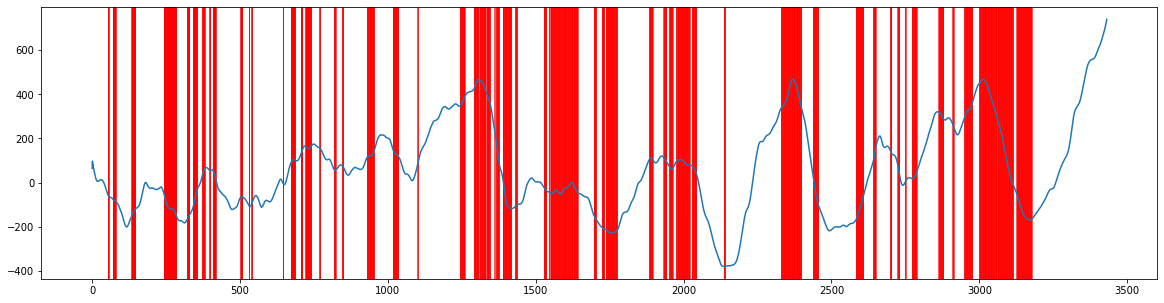

In [82]:
# milton_99
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(respo_dxv)
high=[]
low=[]

for j in range (0,3178):
    for i in range (0,1000):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

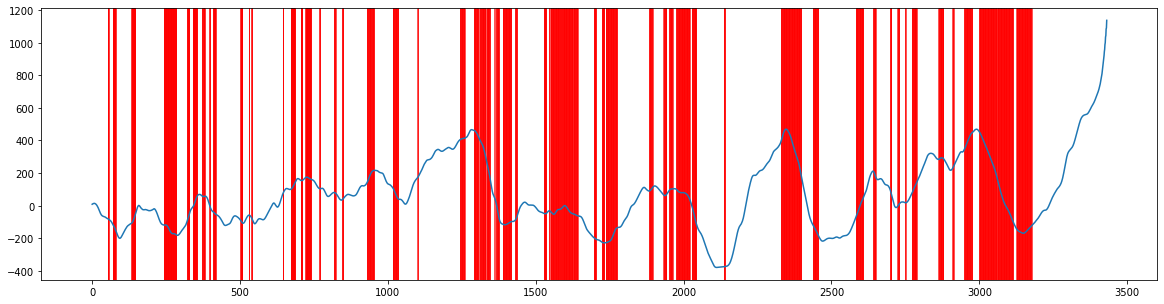

In [81]:
# milton_99
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(delay_dxv)
high=[]
low=[]

for j in range (0,3178):
    for i in range (0,1000):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

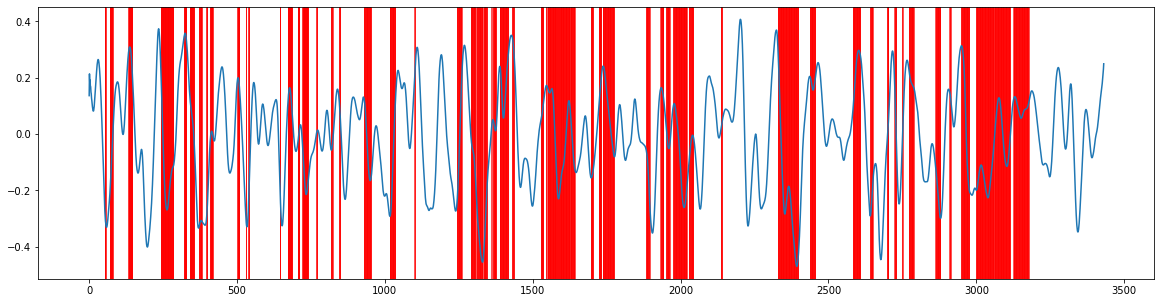

In [80]:
# milton_99
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(respo_phiv)
high=[]
low=[]

for j in range (0,3178):
    for i in range (0,1000):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

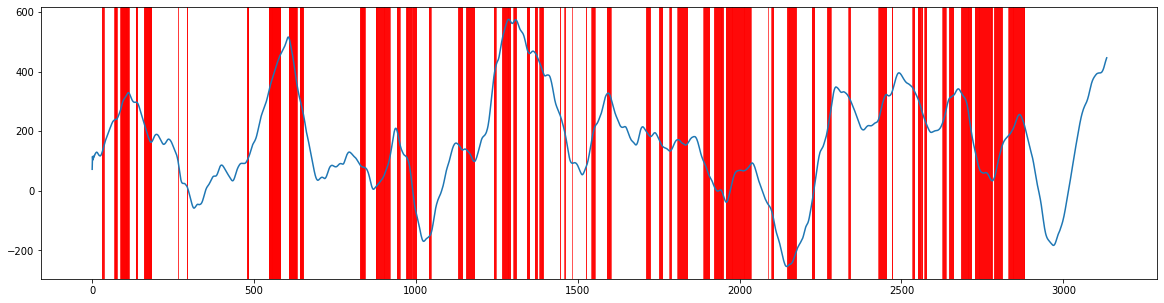

In [51]:
# milton_100
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(respo_dxv)
high=[]
low=[]

for j in range (0,2881):
    for i in range (0,903):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

ERROR! Session/line number was not unique in database. History logging moved to new session 95


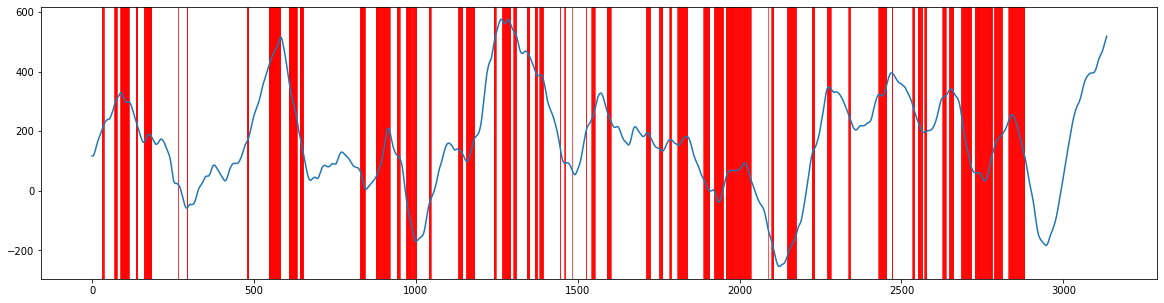

In [50]:
# milton_100
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(delay_dxv)
high=[]
low=[]

for j in range (0,2881):
    for i in range (0,903):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

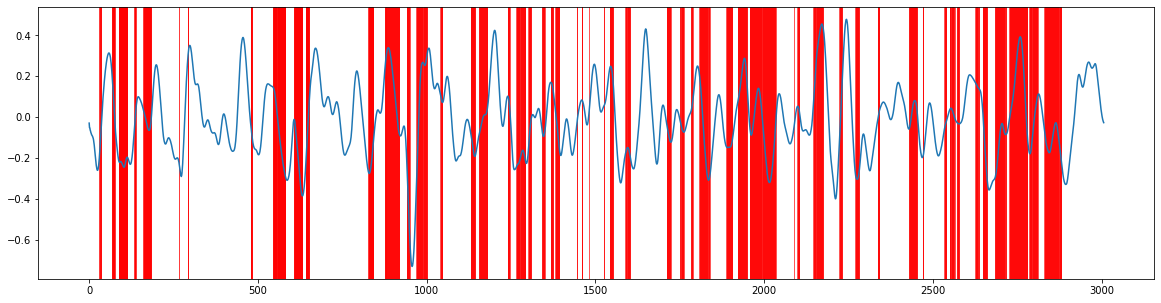

In [49]:
# milton_100
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(respo_phiv)
high=[]
low=[]

for j in range (0,2881):
    for i in range (0,903):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

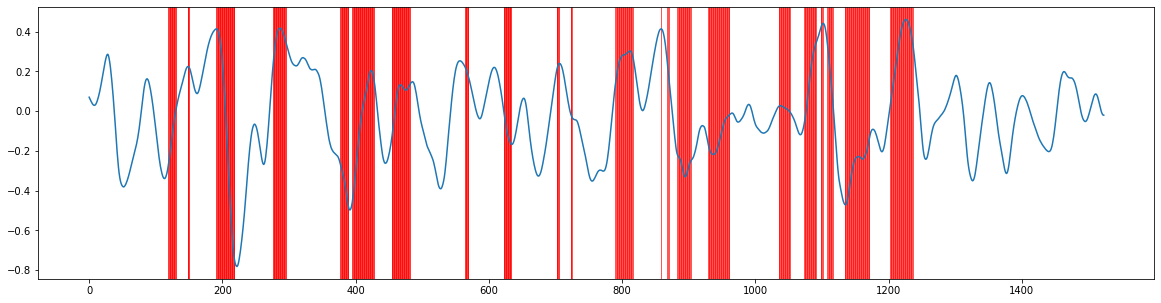

In [200]:
# milton_96
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(delay_phiv)
high=[]
low=[]

for j in range (0,1270):
    for i in range (0,370):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

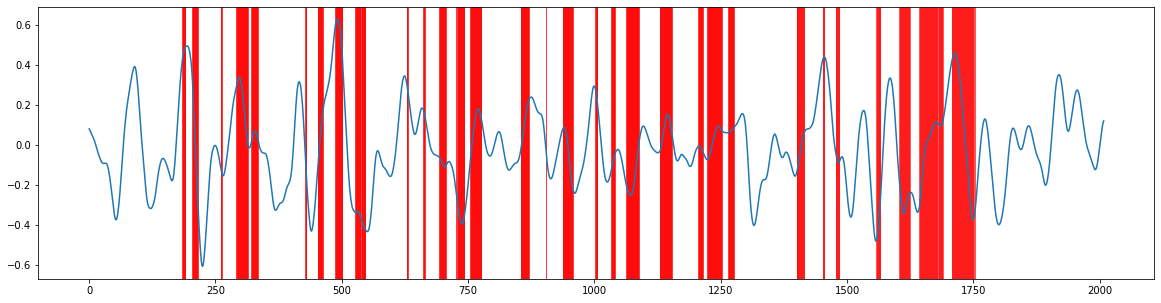

In [165]:
# milton_97
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(delay_phiv)
high=[]
low=[]

for j in range (0,1755):
    for i in range (0,476):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

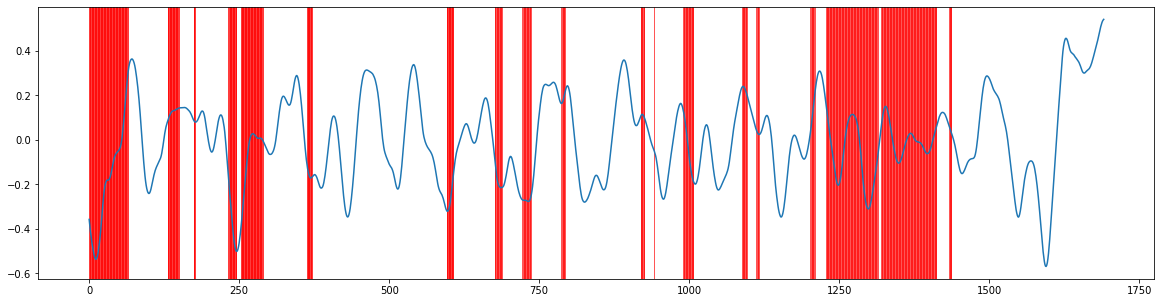

In [137]:
# milton_98
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(delay_phiv)
high=[]
low=[]

for j in range (0,1438):
    for i in range (0,427):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

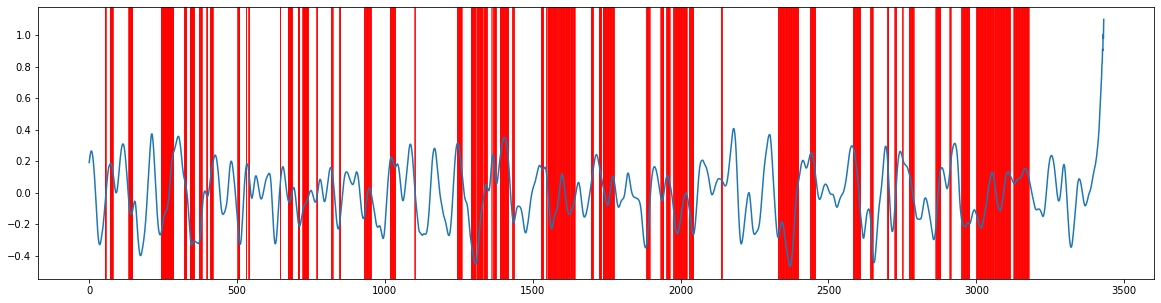

In [106]:
# milton_99
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(delay_phiv)
high=[]
low=[]

for j in range (0,3178):
    for i in range (0,1000):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

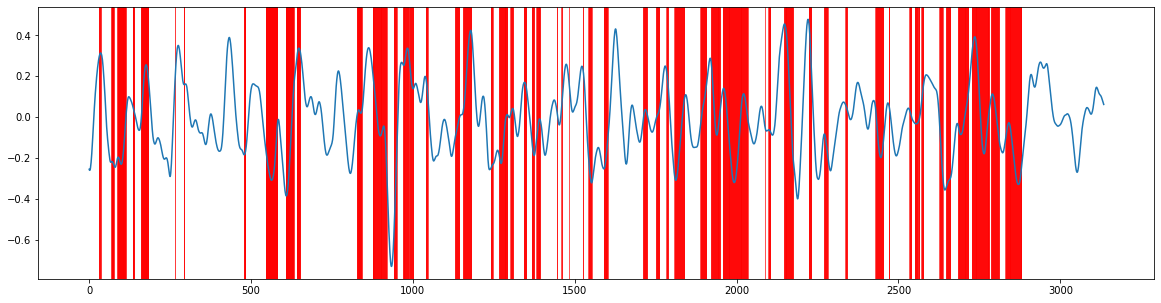

In [56]:
# milton_100
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(delay_phiv)
high=[]
low=[]

for j in range (0,2881):
    for i in range (0,903):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+1
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

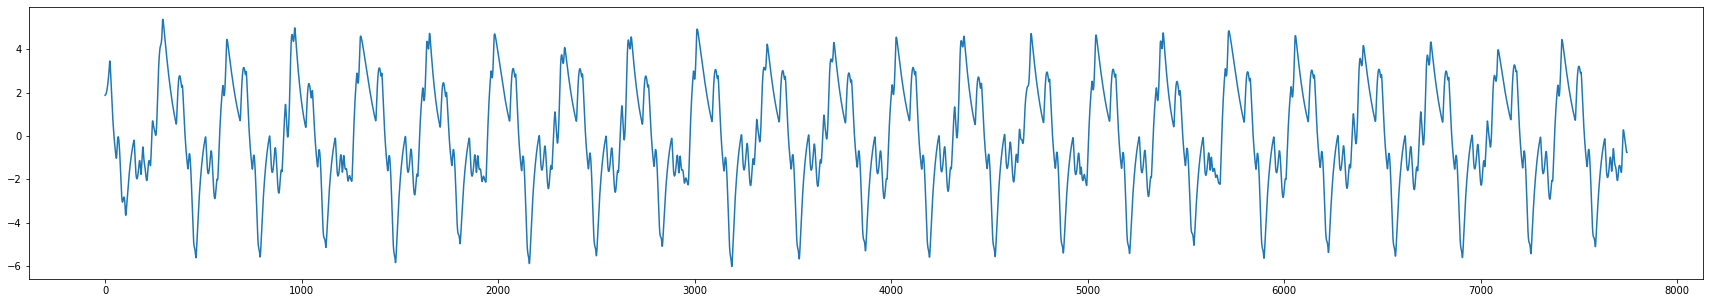

In [408]:
plt.figure(figsize=(30,5))
plt.plot(phiv_sim)

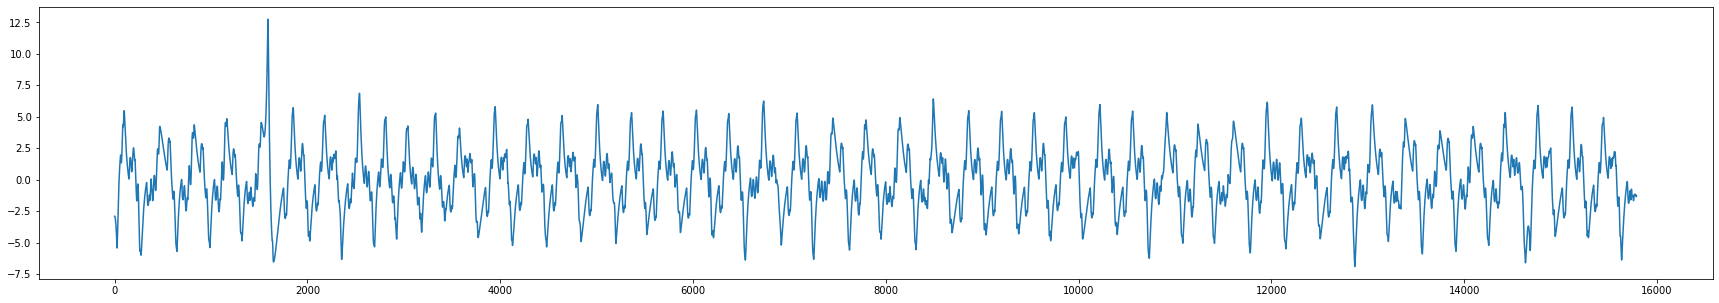

In [367]:
plt.figure(figsize=(30,5))
plt.plot(phiv_sim)

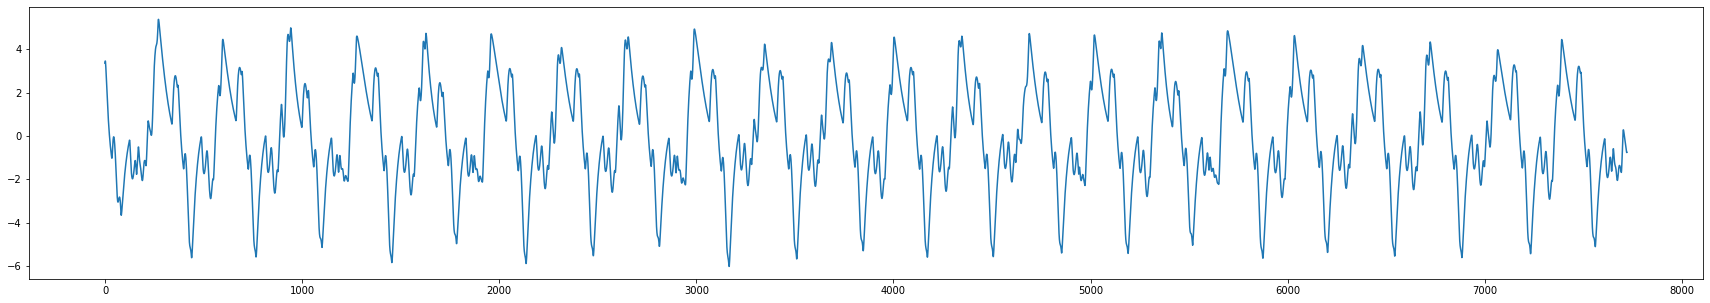

In [409]:
plt.figure(figsize=(30,5))
plt.plot(delay_phiv_sim)

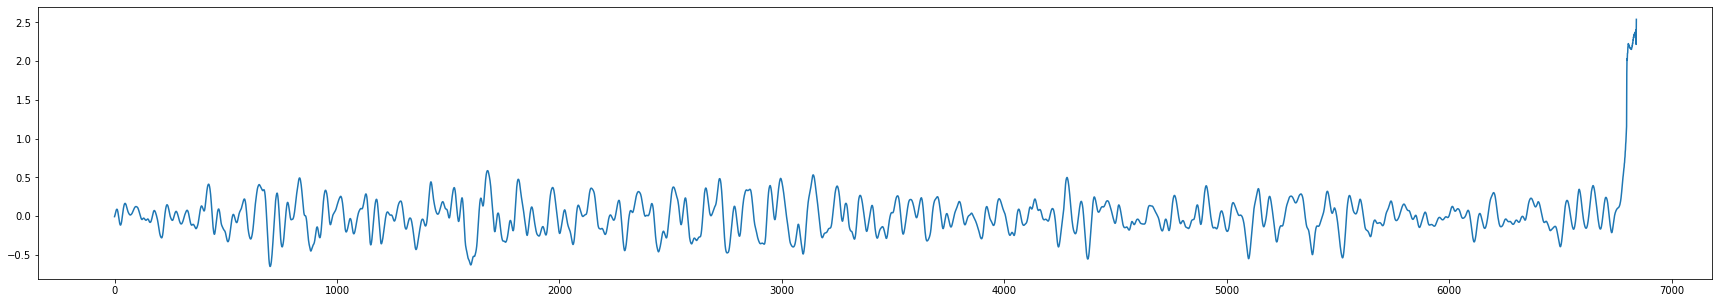

In [44]:
plt.figure(figsize=(30,5))
plt.plot(delay_phiv)

In [407]:
len(delay_phiv_sim)

7722

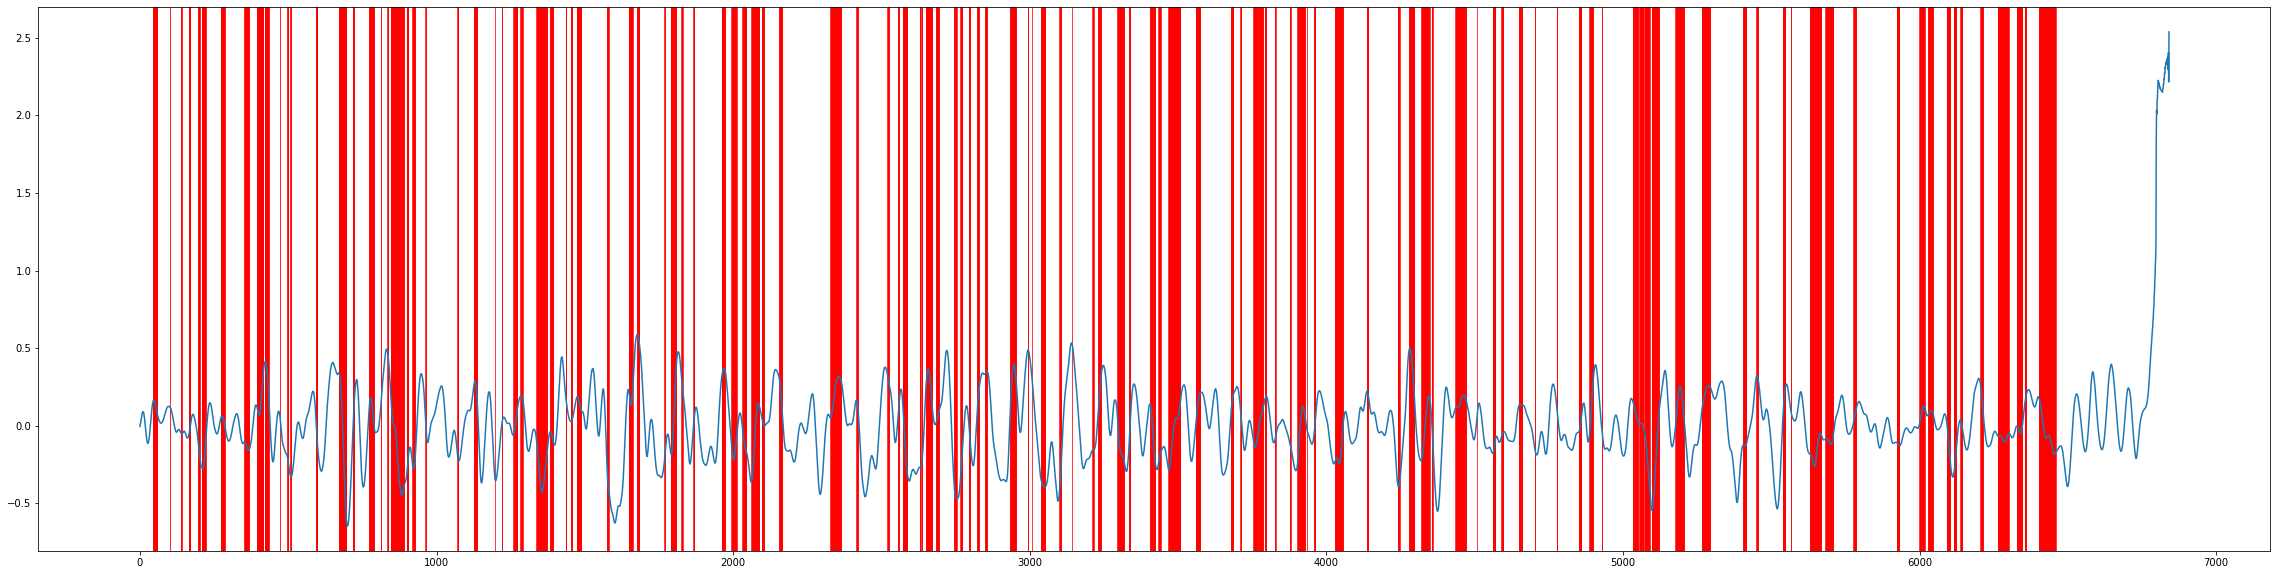

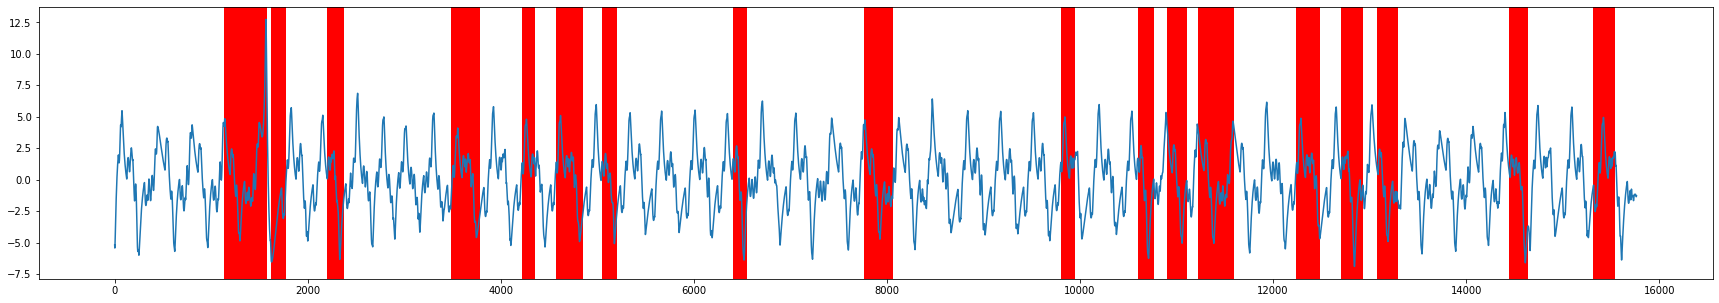

In [373]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.plot(delay_phiv_sim)
high=[]
low=[]

for j in range (0,15512):
    for i in range (0,1092):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+128
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

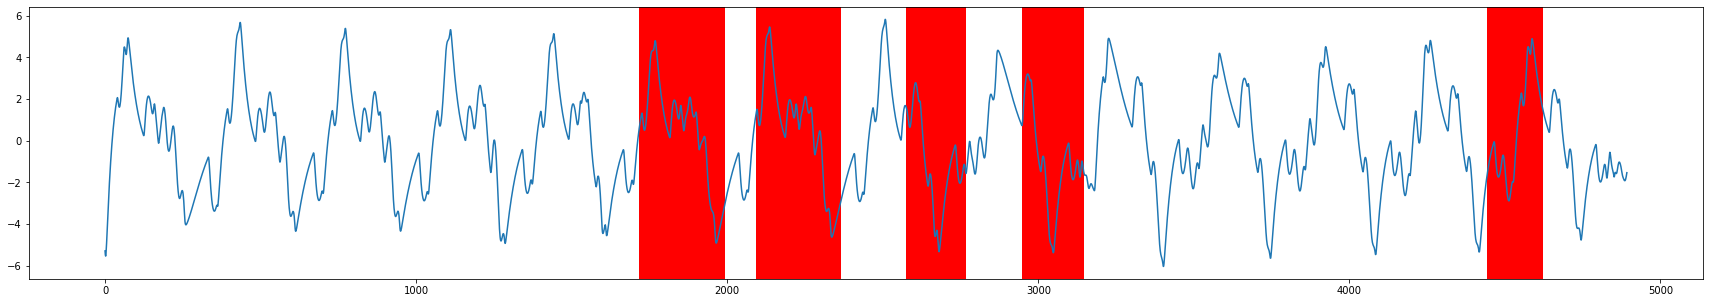

In [323]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.plot(delay_phiv)
high=[]
low=[]

for j in range (0,4893):
    for i in range (0,293):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+128
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

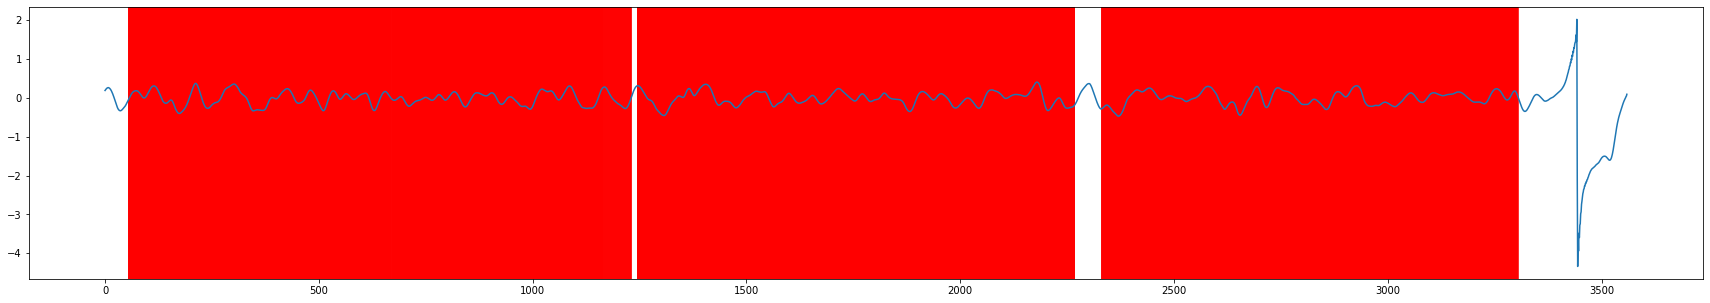

In [233]:
fig, ax = plt.subplots(figsize=(30, 5))
ax.plot(delay_phiv)
high=[]
low=[]

for j in range (0,3570):
    for i in range (0,1000):
     l=not_matched[i]
     low.append(l)
     sum=(not_matched[i]-1)+128
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

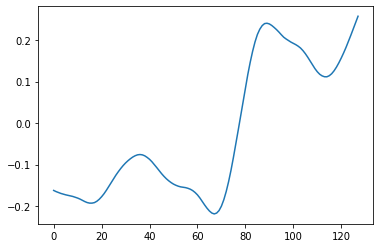

In [171]:
plt.plot(feature1_total[4000])

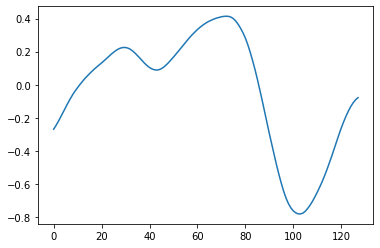

In [57]:
plt.plot(feature1_total[119])

In [ ]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten[0:1000])
high=[]
low=[]

# for j in range (0,1000):
#     for i in range (0,165):
#      l=(not_matched[i]-1)*128
#      low.append(l)
#      sum=128+l
#      high.append(sum)

ax.axvspan(129,128*2, color="blue", alpha=0.3)


In [75]:
# fig, ax = plt.subplots(figsize=(20, 5))
# ax.plot(feature1_total_flatten[0:2000])
# high=[]
# low=[]

# for j in range (0,4000):
#     for i in range (0,5):
#      l=(not_matched[i]-1)*128
#      low.append(l)
#      sum=128+l
#      high.append(sum)

#     ax.axvspan(low[j], high[j], color="red", alpha=0.3)

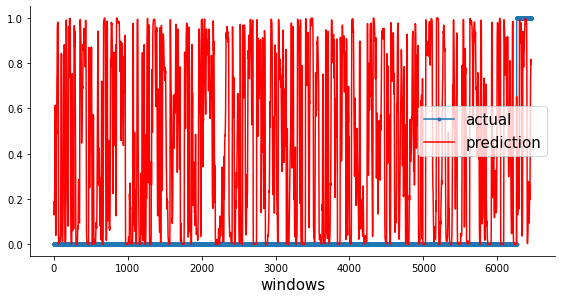

In [449]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels, marker='.', label="actual")
plt.plot(y_prob, 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('windows', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

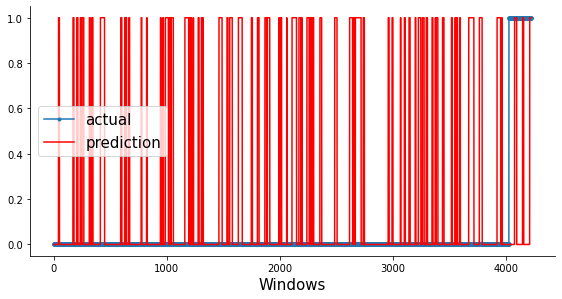

In [138]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels, marker='.', label="actual")
plt.plot(y_out, 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Windows', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

In [54]:
    print("Model Evaluation Started")
    
    y_prob = tf.sigmoid(model.predict(test_examples))
    y_out = (y_prob > 0.84).numpy().astype("int32")
    #y_out = (y_prob > 0.5).numpy().astype("int32")
    target_names = ['No-Fall', 'Fall']
    report = classification_report(test_labels, y_out, target_names=target_names, zero_division = 0)
    
    # with open(f"{rep_root}/test_report_version_{version_catalog}.txt","w") as f:
    #     f.write(report)
    print(report)

Model Evaluation Started
              precision    recall  f1-score   support

     No-Fall       0.88      0.75      0.81      1073
        Fall       0.26      0.47      0.33       197

    accuracy                           0.71      1270
   macro avg       0.57      0.61      0.57      1270
weighted avg       0.79      0.71      0.74      1270



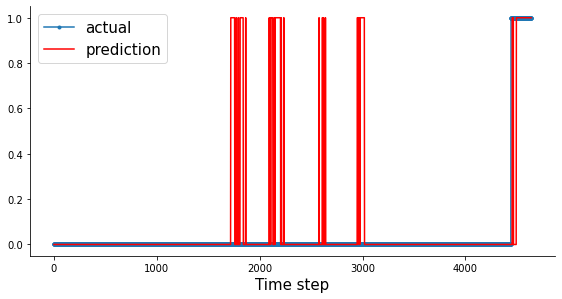

In [41]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels, marker='.', label="actual")
plt.plot(y_out, 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

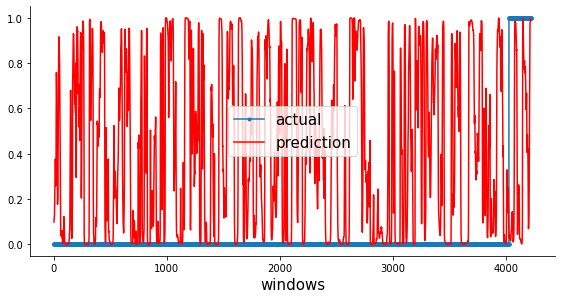

In [62]:
len(test_labels)

4639

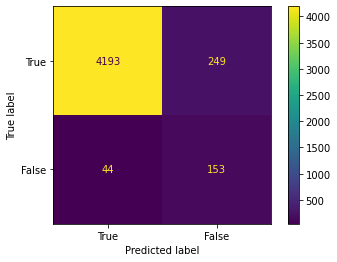

In [61]:
confusion_matrix = metrics.confusion_matrix(test_labels, y_out)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [True,False])

cm_display.plot()
plt.show()

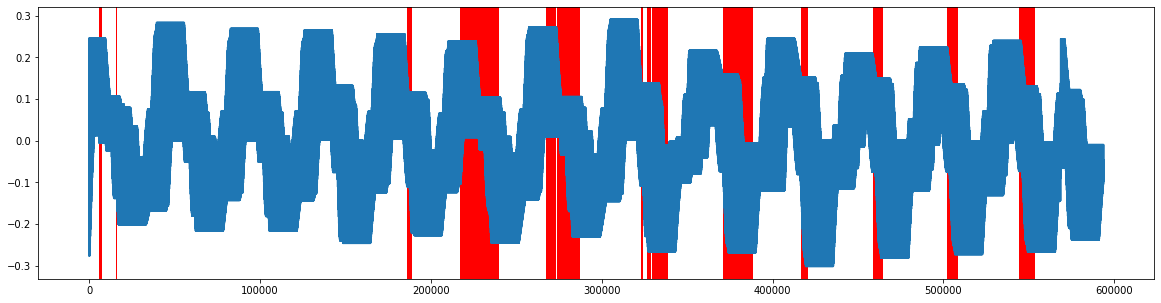

In [72]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,593792):
    for i in range (0,709):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

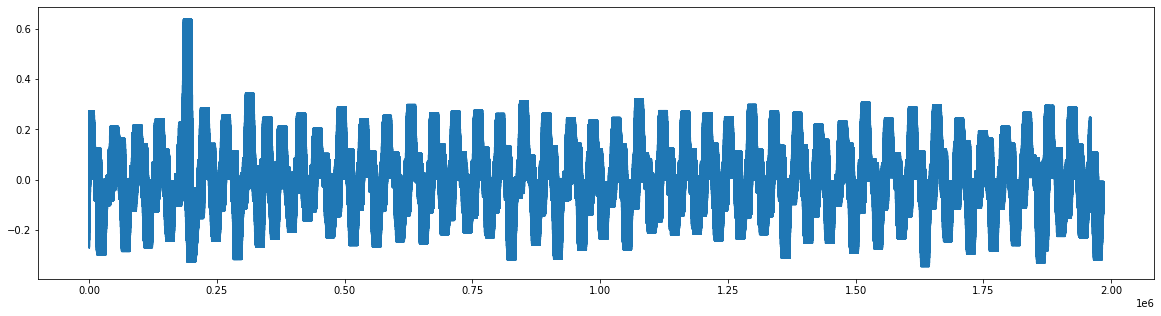

In [36]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)

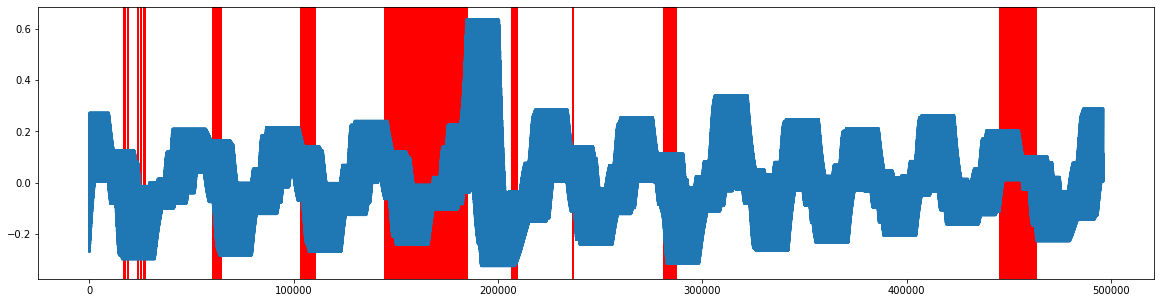

In [48]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten[0:496384])
high=[]
low=[]

for j in range (0,496384):
    for i in range (0,650):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

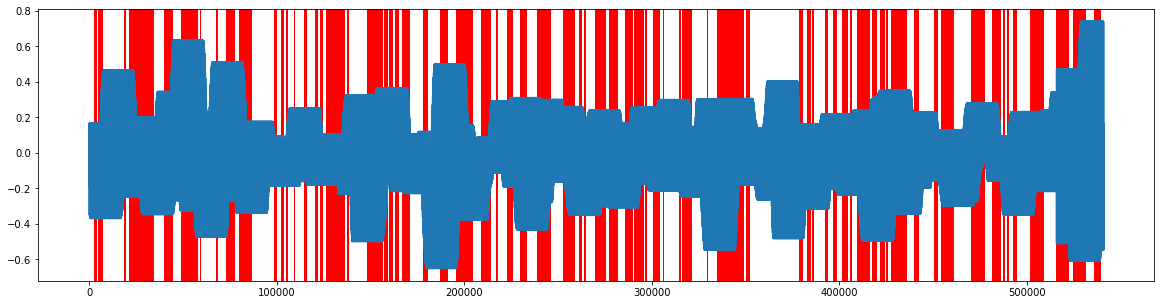

In [32]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,541056):
    for i in range (0,1783):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

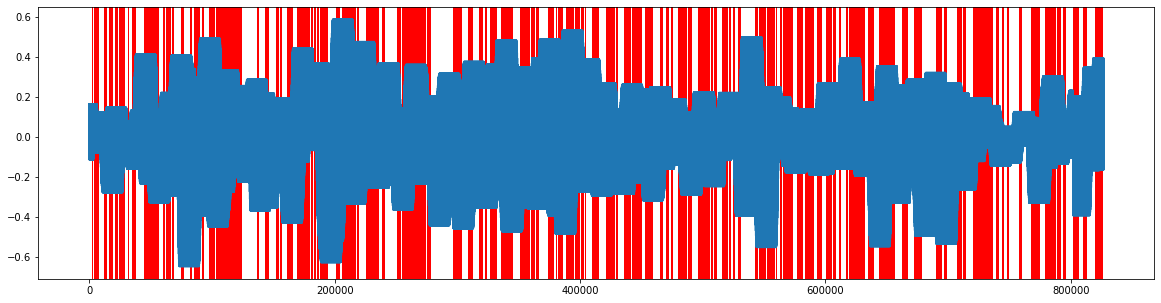

In [293]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,826880):
    for i in range (0,2997):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

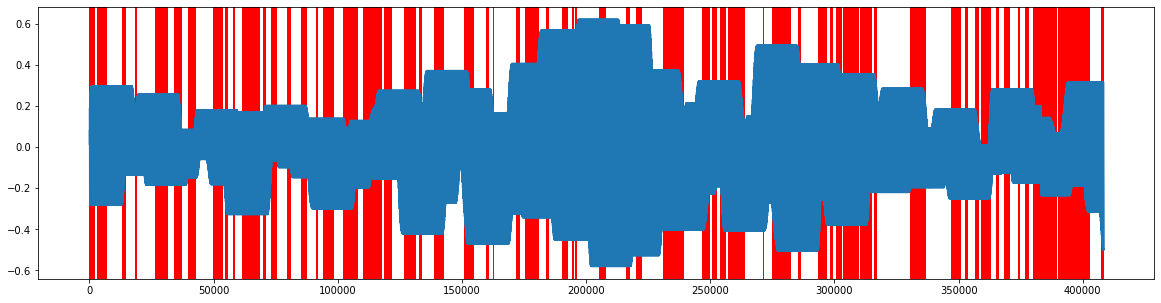

In [271]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,408448):
    for i in range (0,1329):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

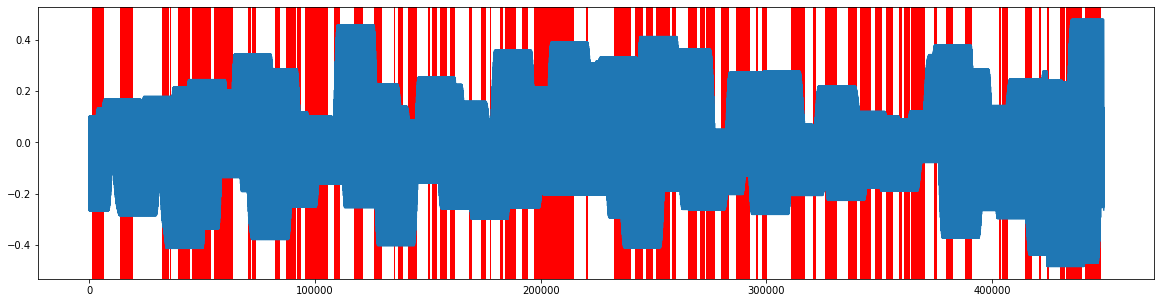

In [248]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,449408):
    for i in range (0,1562):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

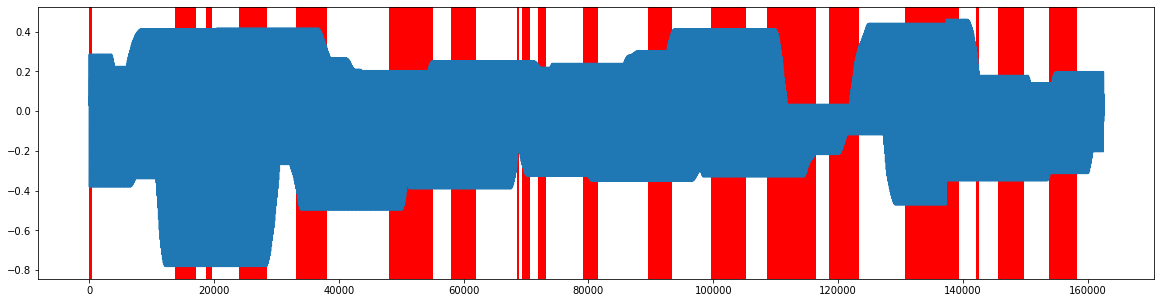

In [220]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,162560):
    for i in range (0,521):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

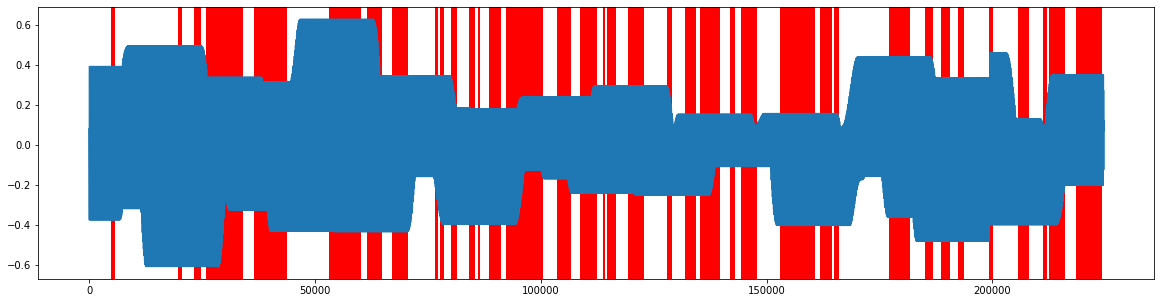

In [195]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,224640):
    for i in range (0,770):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

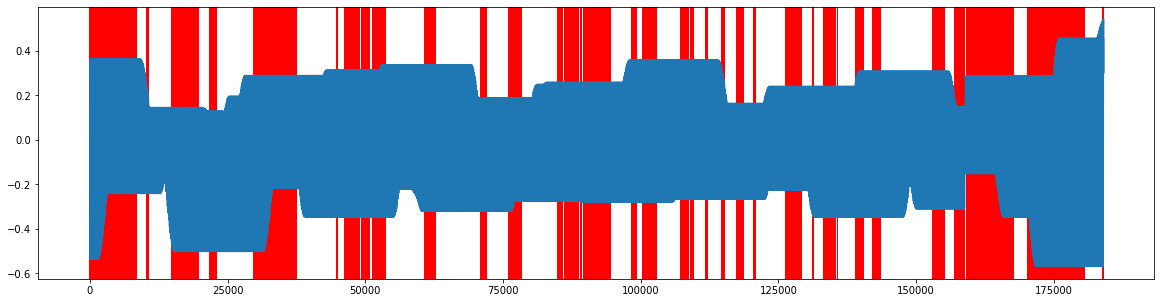

In [169]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,184064):
    for i in range (0,646):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

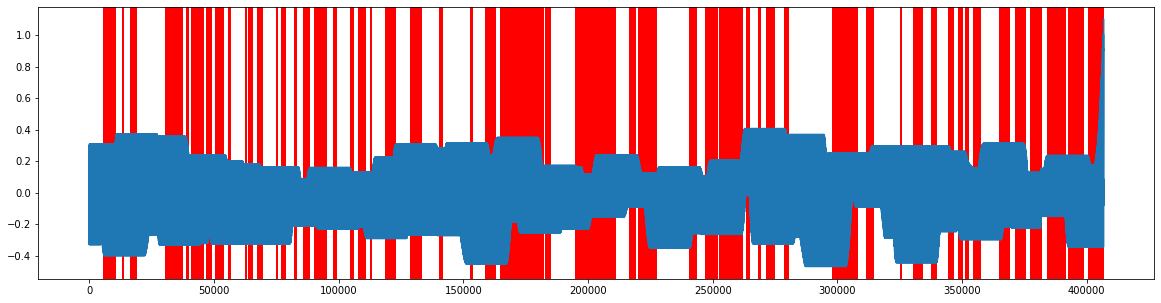

In [132]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,403478):
    for i in range (0,1446):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

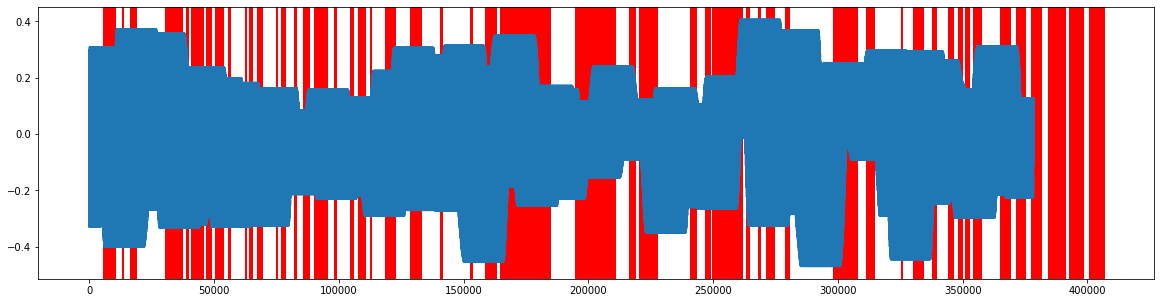

In [118]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,378460):
    for i in range (0,1446):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

In [ ]:
not_matched

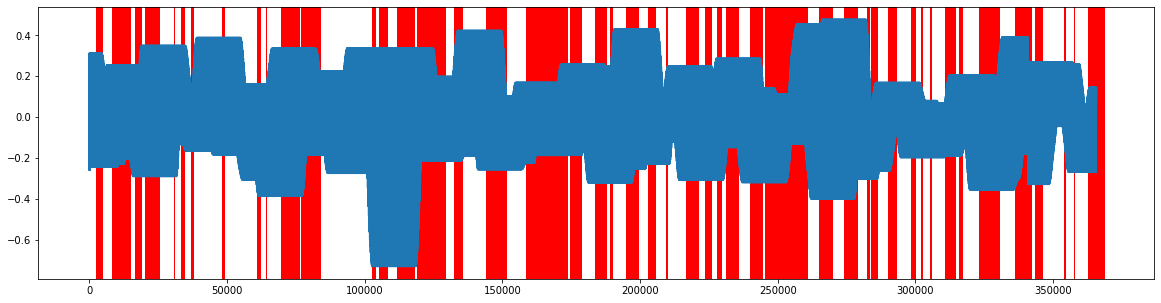

In [61]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,365760):
    for i in range (0,1320):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

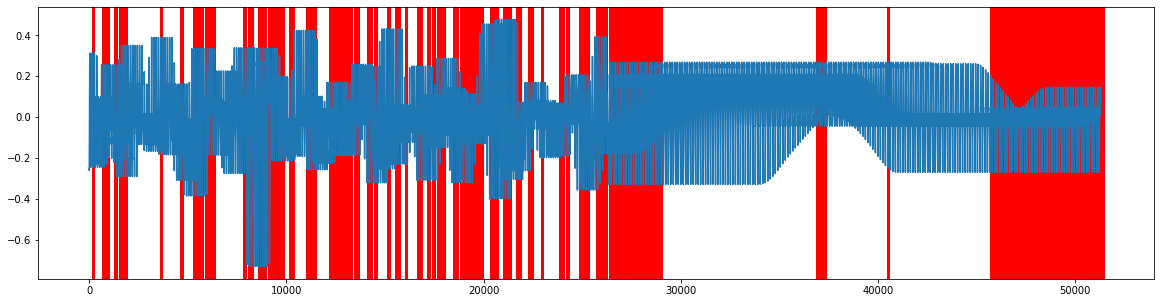

In [78]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,51307):
    for i in range (0,165):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

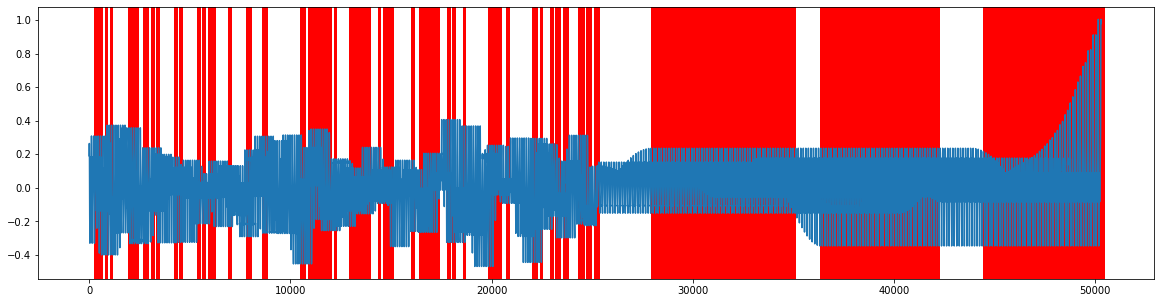

In [118]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,50291):
    for i in range (0,231):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

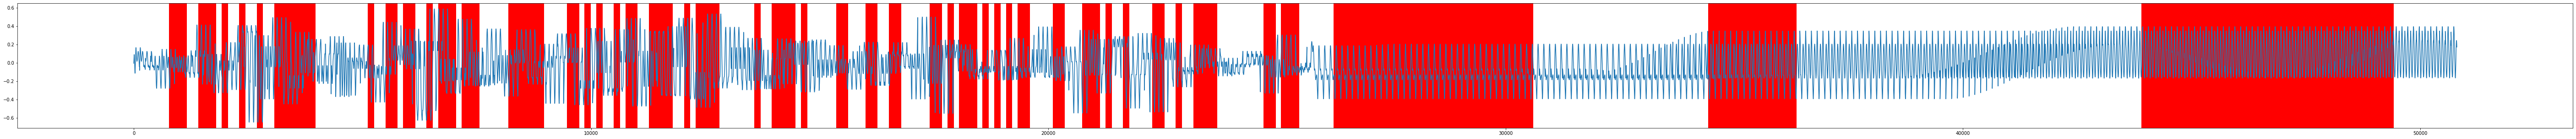

In [230]:
fig, ax = plt.subplots(figsize=(100, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,50799):
    for i in range (0,184):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

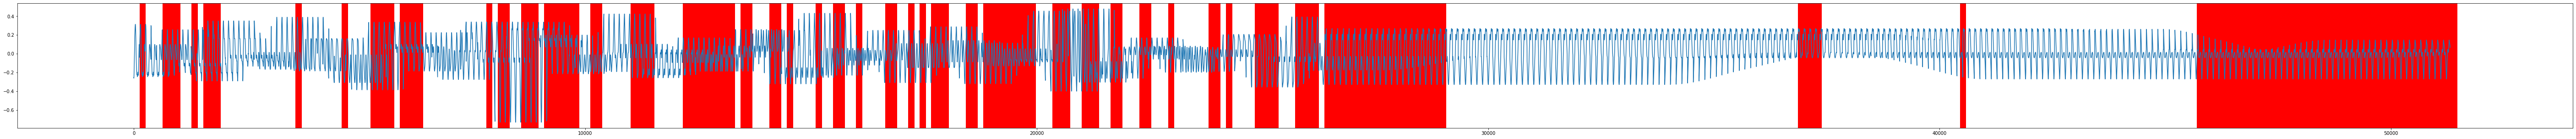

In [71]:
fig, ax = plt.subplots(figsize=(100, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,51307):
    for i in range (0,165):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

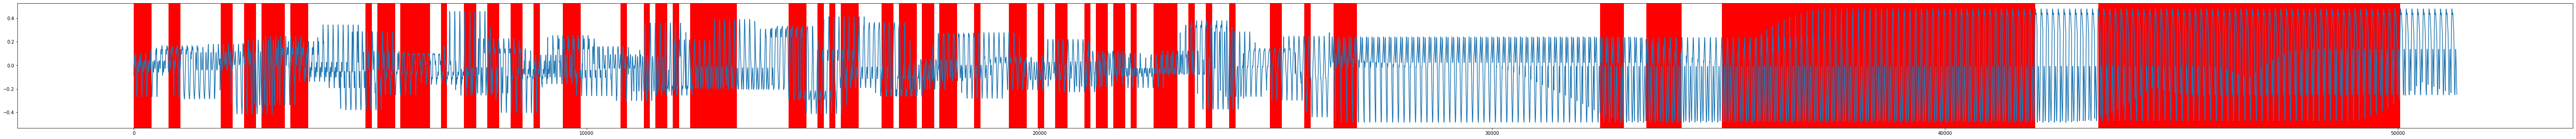

In [176]:
fig, ax = plt.subplots(figsize=(100, 5))
ax.plot(feature1_total_flatten)
high=[]
low=[]

for j in range (0,51307):
    for i in range (0,210):
     l=(not_matched[i]-1)*128
     low.append(l)
     sum=128+l
     high.append(sum)

    ax.axvspan(low[j], high[j], color="red", alpha=0.3)

In [58]:
feature_1=[]
for j in range (0,166):
    for i in range(0,127):
     feature_1.append(test_examples[not_matched[j]][i][0])

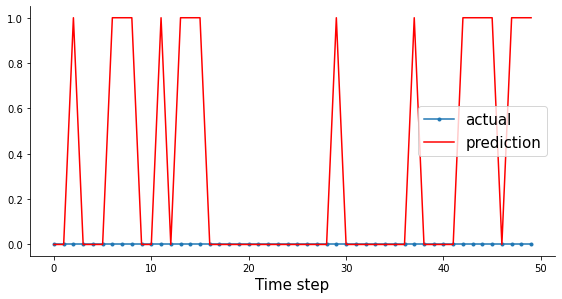

In [82]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels[:50], marker='.', label="actual")
plt.plot(y_out[:50], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

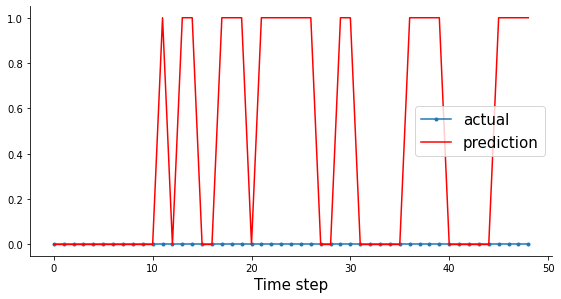

In [83]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels[51:100], marker='.', label="actual")
plt.plot(y_out[51:100], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

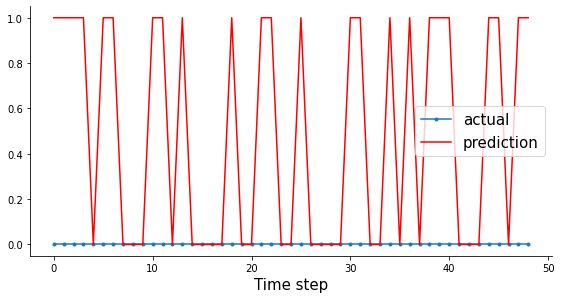

In [84]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels[101:150], marker='.', label="actual")
plt.plot(y_out[101:150], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

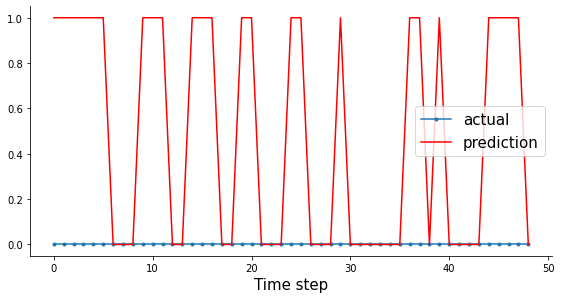

In [85]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels[151:200], marker='.', label="actual")
plt.plot(y_out[151:200], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

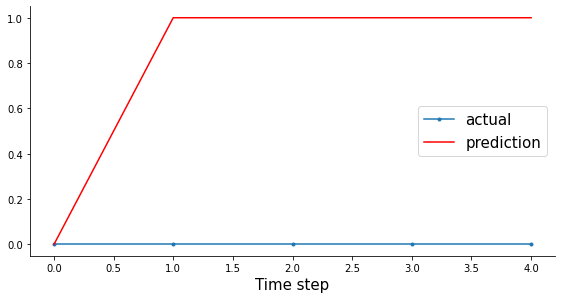

In [86]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels[201:206], marker='.', label="actual")
plt.plot(y_out[201:206], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

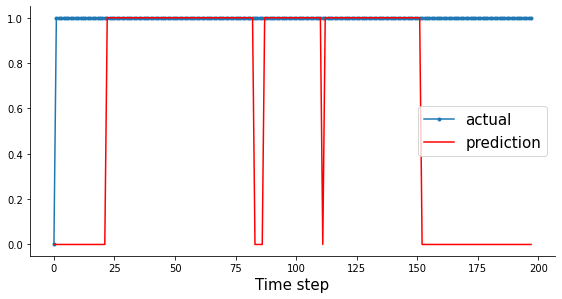

In [77]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels[206:], marker='.', label="actual")
plt.plot(y_out[206:], 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();

In [33]:
# y_out

In [35]:
dat = genfromtxt("/data/stg60/milton_plotdata/Milton_for_prediction/FS_Milton0096.tsv", delimiter='\t')
x1,x2,x3,x4,x5,x6 = np.hsplit(dat,6)
ell_1=((x1-x4)**2+(x2-x5)**2+(x3-x6)**2)**0.5 + 1e-10
ang_sin_x_1=(x1-x4)/ell_1
phi1=np.arcsin(ang_sin_x_1)*180/np.pi

In [136]:
len(test_labels)

404

In [137]:
len(y_out)

404

numpy.ndarray

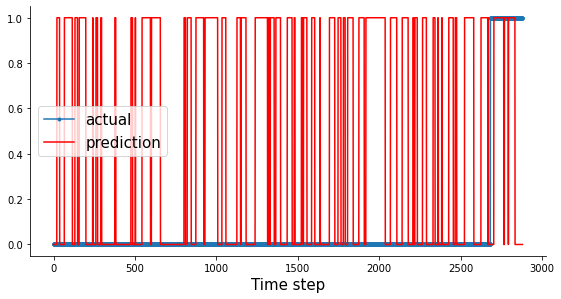

In [59]:
#aa=[x for x in range(200)]
plt.figure(figsize=(8,4))
plt.plot( test_labels, marker='.', label="actual")
plt.plot(y_out, 'r', label="prediction")
# plt.tick_params(left=False, labelleft=True) #remove ticks
plt.tight_layout()
sns.despine(top=True)
plt.subplots_adjust(left=0.07)
#plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.savefig("miltonpred1.png")
plt.show();